In [8]:
## Python in build modules:
import os
import re
from collections import Counter
import time

## EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Metrics (sklearn)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

## Models (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline

## My own functions
from functions import print_report, check_model, vectorize_X

### 1) Exploratory Analysis

In [3]:
## Importing the data

path = 'data/train/'

count = 0
labels = []
contents = []

for label in ['neg','pos']:
    filenames = os.listdir(path + label)
    for filename in filenames:
        count += 1
        with open(os.path.join(path, label, filename), 'r') as f:
            labels.append(1 if label == 'pos' else 0) # 1 is positve 0 is negative
            contents.append(f.read())
print(count)
            
data = pd.DataFrame({
    'contents' : contents,
    'labels': labels,

})

data = data.sample(frac=1, random_state=42).reset_index(drop=True) # This code will shuffle the data (just in case!)

25000


In [4]:
sample = data.sample()
print(sample.contents.iloc[0])
print(sample.labels.iloc[0])

I desperately want to give this movie a 10...I really do. Some movies, especially horror movies are so budget that they are good. A wise-cracking ninja scarecrow who can implement corn cobs as lethal weaponry...definitely fits this 'budget to brilliance' system. The depth of the movie is definitely its strong point and the twists and turns it implements, keeping the audience at the edge of their seats really drives the creepy...ninja... puberty-stricken... pre-thirty year old student...non-cowboy drawing...wise-cracking...son-of-a-bitch scarecrow into the limelight as the creepiest horror icon of the year. All I can really say is, 'can you dig it' and recommend watching movies such as Frankenfish if you enjoy this sort of hilarious horror.<br /><br />(WHAT THE HELL WERE THEY SMOKING!?'
0


#### Just to be clear negative is 0 and positive is 1

In [17]:
data.labels.value_counts()

0    12500
1    12500
Name: labels, dtype: int64

Ok, the data is **completely balanced**.

 ###### At this moment we are going to see 5 examples of each column

In [18]:
for label in data.labels.unique():
    print("negative" if label ==  0 else "positive")
    print("\n")
    for content in data.contents[data.labels == label].sample(2):
        print(content)
        print("\n")

negative


Realistic movie,sure,except for the fact that the characters don't look like to be scared. When Billy Zane tries to kill someone, he feels bad...but he doesn't look like to. That's why I don't like his performance in this movie. Tom Berenger is again playing a soldier. No good thrill, realistic sequences. Not always shooting, that is one great thing. Well filmed. I hate the helicopter sequence, cause only one terrorist kills almost the whole marine bunch...I give it **and a half out of *****


this movie was banned in england? why? tom savini, george romero, dario argento, lucio fulci and others had done far worse before and have continued to so since...<br /><br />this movie has all the basic elements of a decent 70s or early 80's horror film. good looking girls (who can't act to save their lives, by the way), a terrible lightning storm with a torrential downpour, a scythe, a crazy brother wandering around the family estate, and actually a pretty damn good twist at the end.

###### From now on I am going to be using the training data to explore the data so I can get some conclusions.

In [10]:
X = data.contents
y = data.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
train_df = pd.concat([X_train, y_train],axis=1)

In [12]:
y_test.value_counts()

0    4137
1    4113
Name: labels, dtype: int64

In [8]:
train_df.labels.value_counts() # Just checking the proportions haven't change much

1    8387
0    8363
Name: labels, dtype: int64

### Does it has to do something with length?

###### Mean of length

In [29]:
mean_length_full = np.round(X_train.map(len).mean(),2)
train_df = pd.concat([X_train, y_train], axis=1)
mean_lenght_pos = train_df[train_df.labels == 1].contents.map(len).mean()
mean_length_neg = train_df[train_df.labels == 0].contents.map(len).mean()
ratio_pos =  mean_lenght_pos / mean_length_full
ratio_neg =  mean_length_neg / mean_length_full

print(f'Mean length of all reviews: {mean_length_full}')
print(f'Mean length in positive reviews: {mean_lenght_pos}')
print(f'Mean length in negative reviews: {mean_length_neg}')
print(f'Ratio positive: {ratio_pos}')
print(f'Ration negative: {ratio_neg}')

Mean length of all reviews: 1328.28
Mean length in positive reviews: 1352.3945391677596
Mean length in negative reviews: 1304.1033122085375
Ratio positive: 1.0181547107294844
Ration negative: 0.9817985004731966


In [41]:
X_train.map(len).describe()

count    16750.000000
mean      1328.283522
std       1009.709272
min         53.000000
25%        702.250000
50%        981.000000
75%       1612.000000
max      13704.000000
Name: contents, dtype: float64

We can run an **A/B test** here, but there is an indication that the **length** of the commentary has **nothing to do** with the idea if it is positive or negative.

###### Describing of length

In [10]:
print('Describe the length of model when positive:')
print(train_df[train_df.labels == 1].contents.map(len).describe())
print('\n')
print('Describe the length of model when negative:')
print(train_df[train_df.labels == 0].contents.map(len).describe())

Describe the length of model when positive:
count     8387.000000
mean      1352.394539
std       1053.673512
min         70.000000
25%        695.000000
50%        982.000000
75%       1659.500000
max      13704.000000
Name: contents, dtype: float64


Describe the length of model when negative:
count    8363.000000
mean     1304.103312
std       963.063593
min        53.000000
25%       710.000000
50%       981.000000
75%      1554.000000
max      8754.000000
Name: contents, dtype: float64


In [11]:
for i in range(80,101,4):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(train_df[train_df.labels == 1].contents.map(len), i))
    print('negative')
    print(np.percentile(train_df[train_df.labels == 0].contents.map(len), i))

percentage: 80
positive
1917.0
negative
1799.0
percentage: 84
positive
2168.7199999999993
negative
2015.0
percentage: 88
positive
2514.0
negative
2328.120000000001
percentage: 92
positive
3005.0
negative
2755.12
percentage: 96
positive
3815.119999999999
negative
3521.079999999998
percentage: 100
positive
13704.0
negative
8754.0


In [79]:
for i in range(990,1001,2):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(train_df[train_df.labels == 1].contents.map(len), i/10))
    print('negative')
    print(np.percentile(train_df[train_df.labels == 0].contents.map(len), i/10))

percentage: 990
positive
5305.979999999996
negative
5143.779999999975
percentage: 992
positive
5484.296000000002
negative
5336.039999999994
percentage: 994
positive
5669.788000000008
negative
5551.656000000003
percentage: 996
positive
5807.0
negative
5664.655999999999
percentage: 998
positive
5976.435999999969
negative
5879.103999999999
percentage: 1000
positive
13704.0
negative
8754.0


In [90]:
pd.DataFrame(train_df[train_df.labels == 1].contents.map(len)).sort_values('contents', ascending=False).head(10)

,contents
1564,13704
24379,10363
9762,9420
2192,9345
4628,8180
6010,7134
10265,7068
2920,6620
17881,6461
12808,6309


In [91]:
pd.DataFrame(train_df[train_df.labels == 0].contents.map(len)).sort_values('contents', ascending=False).head(10)

,contents
8163,8754
10539,7761
14589,7731
19270,7382
17302,7164
7926,7144
5592,6295
5791,6230
15868,6041
1069,6037


###### Doesn't seem likely. We can see there is a little divergence when the comments start to get longer that people with good reviews will tend to write longer comments. #trustinhumanityrestored (not really)

### What about number of paragraphs?

In [44]:
def count_paragraph(x):
    return x.count('<br /><br />') + 1

In [45]:
paragraphs = pd.concat([train_df.contents.apply(count_paragraph), train_df.labels],axis=1)

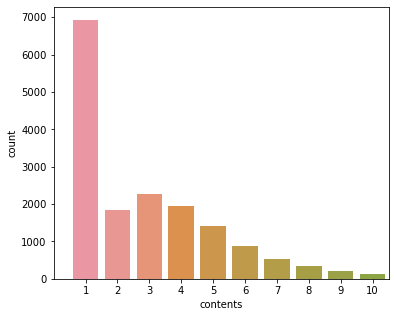

In [76]:
fig, axs = plt.subplots(1,1, figsize=(6,5))
axs = sns.countplot(data=paragraphs, x='contents')
axs.set_xlim(-1,9.5)
plt.show()

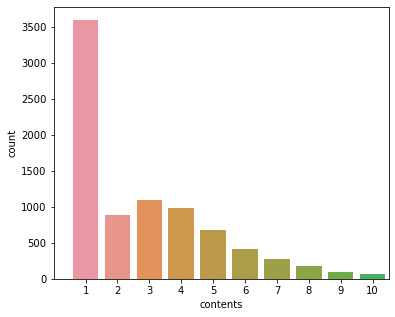

In [74]:
fig, axs = plt.subplots(1,1, figsize=(6,5))
axs = sns.countplot(data=paragraphs[paragraphs.labels == 1], x='contents')
axs.set_xlim(-1,9.5)
plt.show()

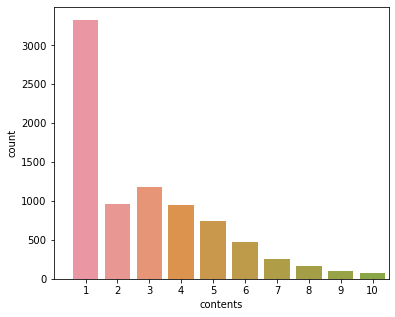

In [77]:
fig, axs = plt.subplots(1,1, figsize=(6,5))
axs = sns.countplot(data=paragraphs[paragraphs.labels == 0], x='contents')
axs.set_xlim(-1,9.5)
plt.show()

In [14]:
print('Describe the n parragraphs of model when positive:')
print(paragraphs[paragraphs.labels == 1].contents.describe())
print('\n')
print('Describe the n parragraphs of model when negative:')
print(paragraphs[paragraphs.labels == 0].contents.describe())

Describe the n parragraphs of model when positive:
count    8387.000000
mean        2.972696
std         2.518918
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        26.000000
Name: contents, dtype: float64


Describe the n parragraphs of model when negative:
count    8363.000000
mean        3.116705
std         2.797950
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        47.000000
Name: contents, dtype: float64


In [15]:
for i in range(80,101,4):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(paragraphs[paragraphs.labels == 1].contents, i))
    print('negative')
    print(np.percentile(paragraphs[paragraphs.labels == 0].contents , i))

percentage: 80
positive
5.0
negative
5.0
percentage: 84
positive
5.0
negative
5.0
percentage: 88
positive
6.0
negative
6.0
percentage: 92
positive
7.0
negative
7.0
percentage: 96
positive
8.0
negative
8.0
percentage: 100
positive
26.0
negative
47.0


###### Doesn't seem likely.  There are cases that are outliers but nothing really there.

In [16]:
## We can actually look for the outliers.

### What about complexity and readiability?

###### Flesch ease

In [92]:
def flesch_readability_ease(text):
    if len(text) > 0:
        text = text.replace("?", ".")
        total_words = len(text.split())
        total_sentences = len(text.split('.'))
        total_sillables = sum(list(map(lambda x: 1 if x in ["a","i","e","o","u","y","A","E","I","O","U","y"] else 0, text)))
        return 206.835 - (1.015 *  total_words/ total_sentences) - 84.6 * (total_sillables / total_words)
    
def remove_outliers(X, y , function):
    boolean = X.apply(function) > 0
    return X[boolean],y[boolean]

It is not that easy, because there are times where you have ? or ! instead of a . And then you may have multiple !? or .

In [95]:
flesch_ease = train_df.contents.map(flesch_readability_ease)
flesch_ease = pd.concat([train_df, flesch_ease], axis=1)
flesch_ease.columns = ['contents', 'labels', 'ease']

In [96]:
print('Describe the ease of model when positive:')
print(flesch_ease[flesch_ease.labels == 1].ease.describe())
print('\n')
print('Describe the ease of model when negative:')
print(flesch_ease[flesch_ease.labels == 0].ease.describe())

Describe the ease of model when positive:
count    8387.000000
mean       39.431971
std        14.529193
min      -134.725000
25%        31.274001
50%        40.201469
75%        48.880102
max        87.286162
Name: ease, dtype: float64


Describe the ease of model when negative:
count    8363.000000
mean       42.887833
std        14.907786
min      -210.452353
25%        35.030668
50%        43.851477
75%        52.018772
max       103.367105
Name: ease, dtype: float64


In [97]:
for i in range(80,101,4):
    print(f'percentage: {i}')
    print('positive')
    print(np.percentile(flesch_ease[flesch_ease.labels == 1].ease, i))
    print('negative')
    print(np.percentile(flesch_ease[flesch_ease.labels == 0].ease, i))

percentage: 80
positive
50.940267383746146
negative
54.076604486839805
percentage: 84
positive
52.82375255102043
negative
55.837750000000035
percentage: 88
positive
54.82556181930695
negative
57.75107385620919
percentage: 92
positive
57.522019145859474
negative
60.312583618136266
percentage: 96
positive
61.7592260392157
negative
64.2719031597529
percentage: 100
positive
87.28616216216219
negative
103.36710526315791


###### The difference in complexity is not crazy, but is there (at least for this model) . Can we use this knowledge in some sort of way? The process is also a little bit memory consuming.

##### There are outliers also outliers

In [151]:
## Outliers of low understandability
flesch_ease[flesch_ease.ease < -0].contents.sample(1).iloc[0]

"Smallville episode Justice is the best episode of Smallville ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! It's my favorite episode of Smallville! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !"

In [23]:
## There are reviews that make little sense

In [79]:
len(flesch_ease[flesch_ease.ease < 0])

155

In [99]:
## Outliers of high understandability
flesch_ease[flesch_ease.ease > 80].contents.sample(1).iloc[0]

"The Fiendish Plot of Dr. Fu Manchu (1980). This is hands down the worst film I've ever seen. What a sad way for a great comedian to go out."

In [26]:
len(flesch_ease[flesch_ease.ease > 80])

21

In [27]:
flesch_ease

,contents,labels,ease
12131,Ernst Lubitsch's contribution to the American ...,1,40.428436
12827,The name (Frau) of the main character is the G...,0,40.173923
2912,"Upon The Straight Story release in 1999, it wa...",1,34.813930
13762,This documentary explores a story covered in P...,1,23.340646
6369,"Tho 35 years old, Groove Tube looks a lot like...",1,-3.854812
...,...,...,...
21575,"Yes, Kazaam is one of those horribly bad movie...",0,35.520517
5390,The 3rd and in my view the best of the Blackad...,1,39.070429
860,!!!!! POSSIBLE SPOILER !!!!!<br /><br />You`d ...,0,29.169732
15795,I cant understand at all why so many Godzilla ...,0,25.185830


###### So how is the data distributed?

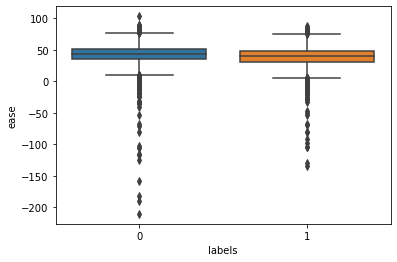

In [98]:
ax = sns.boxplot(x="labels", y="ease",
                    data=flesch_ease)

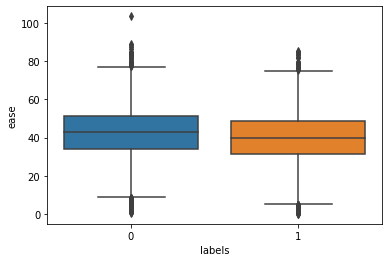

In [29]:
ax = sns.boxplot(x="labels", y="ease",
                    data=flesch_ease[flesch_ease.ease > 0])

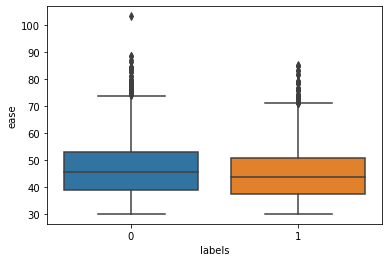

In [30]:
ax = sns.boxplot(x="labels", y="ease",
                    data=flesch_ease[flesch_ease.ease > 30])

###### There is a difference but not that much, when you take outliers positive reviews are just a bit harder to read. At least in this model

###### Most common word for each label

In [34]:
## Most common words in general

cv = CountVectorizer(stop_words={'english'})
list_of_words = cv.fit_transform(X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,the,226374
1,and,110239
2,of,97692
3,to,91327
4,is,72318
5,br,68495
6,it,65011
7,in,62845
8,this,50974
9,that,49116


In [153]:
pos_X_train = train_df.contents[train_df.labels == 1]

cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,1))
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,the,116902
1,and,60296
2,of,51458
3,to,45150
4,is,38653
5,in,33731
6,br,33091
7,it,32486
8,that,23998
9,this,23519


In [154]:
neg_X_train = train_df.contents[train_df.labels == 0]

cv = CountVectorizer(stop_words={'english'})
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,the,116902
1,and,60296
2,of,51458
3,to,45150
4,is,38653
5,in,33731
6,br,33091
7,it,32486
8,that,23998
9,this,23519


#### 2) Removing stop words

In [182]:
with open("stop_words.txt", "r") as stopwords:
    stopwords=[i.replace(","").strip() for i in stopwords]

SyntaxError: EOL while scanning string literal (<ipython-input-182-132cbefa9b97>, line 2)

In [180]:
stopwords

['"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aint", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "arent", "arise", "around", "as", "as", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "beco

In [156]:
pos_X_train = train_df.contents[train_df.labels == 1]

cv = CountVectorizer(stop_words={'english'}, max_df=.2)
list_of_words = cv.fit_transform(pos_X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
print(words)

['films', 'character', 'movies', 'characters', 'man', 'then', 'show', 'little', 'where', 'could', 'being', 'does', 'any', 'over', 'while', 'know', 'here', 'did', 'these', 'years']


### 2) Running the first models

#### Model number 1

In [31]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english')

for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 63,738 
The amount of time it took to vectorize was: 2.871718000000044

Multinomial Naive Bayes
Confusion Matrix
[[3645  520]
 [ 693 3392]]


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4165
           1       0.87      0.83      0.85      4085

    accuracy                           0.85      8250
   macro avg       0.85      0.85      0.85      8250
weighted avg       0.85      0.85      0.85      8250



Other Metrics:
Pression Score: 0.8670756646216768
Accuracy Score: 0.8529696969696969
Recall Score: 0.8303549571603427
f1 Score 0.8483181192947354
_________________________________________________


This is the base Multinominal only using basic stop words in english. It is using a basic ngram_range of 1,1. 

#### Model number 2

In [14]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1,3))

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 2,991,762 
The amount of time it took to vectorize was: 14.126662

Multinomial Naive Bayes
Confusion Matrix
[[3663  474]
 [ 545 3568]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4137
           1       0.88      0.87      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8827313211281543
Accuracy Score: 0.8764848484848485
Recall Score: 0.8674933138828106
f1 Score 0.8750459840588596
_________________________________________________


The second model performs better, specially in recall. However it takes too much time to perform.

In [ ]:
#### Model number 3

In [49]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1, 3))
X_train_sample = X_train.sample(frac=.8, random_state=50)
y_train_sample = y_train.sample(frac=.8, random_state=50)

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train_sample, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train_sample)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 2,446,414 
The amount of time it took to vectorize was: 12.615819999999985

Multinomial Naive Bayes
Confusion Matrix
[[3610  499]
 [ 559 3582]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4109
           1       0.88      0.87      0.87      4141

    accuracy                           0.87      8250
   macro avg       0.87      0.87      0.87      8250
weighted avg       0.87      0.87      0.87      8250



Other Metrics:
Pression Score: 0.8777260475373683
Accuracy Score: 0.8717575757575757
Recall Score: 0.8650084520647187
f1 Score 0.8713208465093653
_________________________________________________


Feeding the model with less amount of data; seems to make the model run worse, which was expected. I need to check with an a/b testing though.

#### Model number 4

In [64]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1,5))

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train_sample, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train_sample)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 5,342,619 
The amount of time it took to vectorize was: 21.06203400000001

Multinomial Naive Bayes
Confusion Matrix
[[3643  494]
 [ 527 3586]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4137
           1       0.88      0.87      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.878921568627451
Accuracy Score: 0.8762424242424243
Recall Score: 0.8718696814976903
f1 Score 0.8753814231661174
_________________________________________________


In [17]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words='english', ngram_range=(1,5) , max_df=.1)

for vec ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 6,608,794 
The amount of time it took to vectorize was: 30.867364000000002

Multinomial Naive Bayes
Confusion Matrix
[[3611  526]
 [ 455 3658]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4137
           1       0.87      0.89      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.874282982791587
Accuracy Score: 0.881090909090909
Recall Score: 0.8893751519572088
f1 Score 0.8817644931903098
_________________________________________________


#### Model number 5

In [40]:
mnb = MultinomialNB()
stop_words = 'the and of to is in br it that this as with for was film movie his on are have be one'.split(' ')
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3))

for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 16.878854000000004

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


This was a mechanical way to extract words but I have an idea of how to authomate the process.

### 3) Tweeking Parameters

#### Max df

Max_df and min_df are use to eliminate words based on some threshold. The idea is that some tokens instead of helping
the model are only noise.
<br>There are two basic approaches to handle this types of words. We can eliminate very common words(using **max_df**) or we can eliminate very rare words using min_df.
<br><br> The idea with max_df is that if a word appears at least in a certain percentage of the sample then it should be removed.
<br><br> The idea with min_df is that if a word appears in less document that in the theshold it should be ignored. 
<br><br> Notice that max_df will have a lot of overlapping with stopwords.

In [45]:
for i in range(4,11,1):
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=i/10)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i/10}')
    print(X_train_vectorized.shape)

This is the shape for 0.4
(16750, 3713413)
This is the shape for 0.5
(16750, 3713428)
This is the shape for 0.6
(16750, 3713440)
This is the shape for 0.7
(16750, 3713446)
This is the shape for 0.8
(16750, 3713448)
This is the shape for 0.9
(16750, 3713452)
This is the shape for 1.0
(16750, 3713457)


In [44]:
for i in range(4,11,1):
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,1), max_df=i/10)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i/10}')
    print(X_train_vectorized.shape)

This is the shape for 0.4
(16750, 63655)
This is the shape for 0.5
(16750, 63670)
This is the shape for 0.6
(16750, 63680)
This is the shape for 0.7
(16750, 63685)
This is the shape for 0.8
(16750, 63687)
This is the shape for 0.9
(16750, 63691)
This is the shape for 1.0
(16750, 63696)


I don't see much of a difference in this max_df, even at really low percentages. But, never know if this can really affect the model.

In [46]:
## Most common words in general

cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,1), max_df=.2)
list_of_words = cv.fit_transform(X_train).toarray()
sum_of_words = pd.Series(list_of_words.sum(axis=0))
sum_of_words = sum_of_words.sort_values(ascending=False)[:20]

words = []
numbers = []

for num in sum_of_words.index:
    word = (list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(num)])
    numbers.append(sum_of_words.loc[num])
    words.append(word)
    
pd.DataFrame({
    "words" : words,
    "counts" : numbers,
})

,words,counts
0,character,4746
1,films,4627
2,life,4399
3,where,4350
4,plot,4349
5,little,4309
6,show,4296
7,love,4287
8,over,4270
9,best,4199


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=59)

#### Model number 1

In [30]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=10, max_df=.4 )

for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 80,245 
The amount of time it took to vectorize was: 14.630815999999982

Multinomial Naive Bayes
Confusion Matrix
[[3663  502]
 [ 529 3556]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4165
           1       0.88      0.87      0.87      4085

    accuracy                           0.88      8250
   macro avg       0.88      0.87      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8762937407589946
Accuracy Score: 0.875030303030303
Recall Score: 0.8705018359853122
f1 Score 0.8733881861721725
_________________________________________________


In [48]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=.3)

for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 17.942894000000024

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


This models perform quiet similar to the models that where run with the decided stop_words (which was expected)

#### Model number 3

In [49]:
mnb = MultinomialNB()
stop_words = 'the and of to is in br it that this as with for was film movie his on are have be one'.split(' ')
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), max_df=.3)


for cv ,clf, clf_name in [(vec , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(vec, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,718,004 
The amount of time it took to vectorize was: 18.375955000000033

Multinomial Naive Bayes
Confusion Matrix
[[3751  386]
 [ 530 3583]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4137
           1       0.90      0.87      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.9027462836986646
Accuracy Score: 0.888969696969697
Recall Score: 0.8711402868952103
f1 Score 0.886661717396684
_________________________________________________


There was a lot of overlap, and this little amount of words really make a difference in the performance of the model

#### Models using min_df alone

In [53]:
for i in [2,5,10,15,20,25,30,50]:
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,1), min_df=i)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i}')
    print(X_train_vectorized.shape)

This is the shape for 2
(16750, 38025)
This is the shape for 5
(16750, 22483)
This is the shape for 10
(16750, 14804)
This is the shape for 15
(16750, 11432)
This is the shape for 20
(16750, 9375)
This is the shape for 25
(16750, 7969)
This is the shape for 30
(16750, 7034)
This is the shape for 50
(16750, 4803)


In [57]:
for i in [2,5,10,15,20,25,30,50]:
    count_vectorizer = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=i)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i}')
    print(X_train_vectorized.shape)

This is the shape for 2
(16750, 622962)
This is the shape for 5
(16750, 175106)
This is the shape for 10
(16750, 80501)
This is the shape for 15
(16750, 52307)
This is the shape for 20
(16750, 38496)
This is the shape for 25
(16750, 30253)
This is the shape for 30
(16750, 24837)
This is the shape for 50
(16750, 14359)


In [54]:
for i in [2,5,10,15,20,25,30,50]:
    count_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=i)
    X_train_vectorized = count_vectorizer.fit_transform(X_train)
    print(f'This is the shape for {i}')
    print(X_train_vectorized.shape)

This is the shape for 2
(16750, 408279)
This is the shape for 5
(16750, 99325)
This is the shape for 10
(16750, 43980)
This is the shape for 15
(16750, 28243)
This is the shape for 20
(16750, 20688)
This is the shape for 25
(16750, 16255)
This is the shape for 30
(16750, 13391)
This is the shape for 50
(16750, 7828)


#### Model number 4

In [62]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=5)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 99,325 
The amount of time it took to vectorize was: 11.592953999999963

Multinomial Naive Bayes
Confusion Matrix
[[3639  498]
 [ 505 3608]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4137
           1       0.88      0.88      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8787140769605456
Accuracy Score: 0.8784242424242424
Recall Score: 0.8772185752492099
f1 Score 0.8779656892566006
_________________________________________________


#### Model number 5

In [63]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=10)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 43,980 
The amount of time it took to vectorize was: 10.890859999999975

Multinomial Naive Bayes
Confusion Matrix
[[3592  545]
 [ 510 3603]]


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4137
           1       0.87      0.88      0.87      4113

    accuracy                           0.87      8250
   macro avg       0.87      0.87      0.87      8250
weighted avg       0.87      0.87      0.87      8250



Other Metrics:
Pression Score: 0.8686113789778206
Accuracy Score: 0.8721212121212121
Recall Score: 0.8760029175784099
f1 Score 0.8722914901343661
_________________________________________________


Lets try some mixture of both

#### Model number 6

In [67]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=10, max_df=0.3)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 80,433 
The amount of time it took to vectorize was: 13.848969000000011

Multinomial Naive Bayes
Confusion Matrix
[[3630  507]
 [ 445 3668]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4137
           1       0.88      0.89      0.89      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.878562874251497
Accuracy Score: 0.8846060606060606
Recall Score: 0.8918064672988086
f1 Score 0.8851351351351352
_________________________________________________


#### Model number 7

In [19]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=10, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 80,457 
The amount of time it took to vectorize was: 15.139723000000004

Multinomial Naive Bayes
Confusion Matrix
[[3628  509]
 [ 449 3664]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4137
           1       0.88      0.89      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.8780254013898874
Accuracy Score: 0.8838787878787879
Recall Score: 0.8908339411621687
f1 Score 0.8843832971276853
_________________________________________________


The combination of both doesn't look better (need more testing to check if it is the same) but it may be faster.

#### Model number 8

In [71]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=5, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 175,062 
The amount of time it took to vectorize was: 13.904557000000068

Multinomial Naive Bayes
Confusion Matrix
[[3661  476]
 [ 474 3639]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4137
           1       0.88      0.88      0.88      4113

    accuracy                           0.88      8250
   macro avg       0.88      0.88      0.88      8250
weighted avg       0.88      0.88      0.88      8250



Other Metrics:
Pression Score: 0.884325637910085
Accuracy Score: 0.8848484848484849
Recall Score: 0.8847556528081693
f1 Score 0.8845405930967428
_________________________________________________


#### Model number 9

In [72]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=2, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 622,918 
The amount of time it took to vectorize was: 15.014494000000013

Multinomial Naive Bayes
Confusion Matrix
[[3704  433]
 [ 467 3646]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4137
           1       0.89      0.89      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.8938465310125031
Accuracy Score: 0.8909090909090909
Recall Score: 0.886457573547289
f1 Score 0.89013671875
_________________________________________________


I would like to understand exactly why when you start to increase the min_df you get a worse score if also you are working with a max_df

#### Model number 10

In [99]:
new_X_train, new_y_train = remove_outliers(X_train, y_train , flesch_readability_ease)
new_X_test, new_y_test = remove_outliers(X_test, y_test , flesch_readability_ease)

In [100]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=0.3)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, new_X_train, new_X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, new_y_train)
    check_model(clf, X_test_vectorized, new_y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 3,683,278 
The amount of time it took to vectorize was: 19.877337999999995

Multinomial Naive Bayes
Confusion Matrix
[[3698  410]
 [ 461 3611]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4108
           1       0.90      0.89      0.89      4072

    accuracy                           0.89      8180
   macro avg       0.89      0.89      0.89      8180
weighted avg       0.89      0.89      0.89      8180



Other Metrics:
Pression Score: 0.8980353145983586
Accuracy Score: 0.893520782396088
Recall Score: 0.8867878192534381
f1 Score 0.8923761275176078
_________________________________________________


In [101]:
## The really impresive stuff is that if you run the code only with the outliers then you get a perfect score. 
## At least in this split

#### Model number 11

In [102]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(2,3), min_df=2, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 584,934 
The amount of time it took to vectorize was: 12.373823999999999

Multinomial Naive Bayes
Confusion Matrix
[[3704  433]
 [ 470 3643]]


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4137
           1       0.89      0.89      0.89      4113

    accuracy                           0.89      8250
   macro avg       0.89      0.89      0.89      8250
weighted avg       0.89      0.89      0.89      8250



Other Metrics:
Pression Score: 0.8937684003925417
Accuracy Score: 0.8905454545454545
Recall Score: 0.8857281789448092
f1 Score 0.8897301257784832
_________________________________________________


In [103]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(3,3), min_df=2, max_df=0.4)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_test_vectorized, y_test)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 302,349 
The amount of time it took to vectorize was: 7.228403

Multinomial Naive Bayes
Confusion Matrix
[[3603  534]
 [ 548 3565]]


Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4137
           1       0.87      0.87      0.87      4113

    accuracy                           0.87      8250
   macro avg       0.87      0.87      0.87      8250
weighted avg       0.87      0.87      0.87      8250



Other Metrics:
Pression Score: 0.8697243230056111
Accuracy Score: 0.8688484848484849
Recall Score: 0.8667639192803307
f1 Score 0.8682415976619582
_________________________________________________


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=30)

mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), max_df=0.4, min_df=3)


for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
    # Vectorization
    start = time.process_time()
    X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
    print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
    print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')
    
    # Running the model
    print(clf_name)
    clf.fit(X_train_vectorized, y_train)
    check_model(clf, X_train_vectorized, y_train)
    print("_________________________________________________")

The amount of features in the Vectorized X train is: 204,045 
The amount of time it took to vectorize was: 12.635899000000109

Multinomial Naive Bayes
Confusion Matrix
[[4864   84]
 [ 146 4906]]


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4948
           1       0.98      0.97      0.98      5052

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Other Metrics:
Pression Score: 0.9831663326653307
Accuracy Score: 0.977
Recall Score: 0.9711005542359462
f1 Score 0.9770961959768971
_________________________________________________


In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time

In [79]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1,3), min_df=5)),
        ("clf", MultinomialNB()),
    ]
)

parameters = {
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 97.034s

Best score: 0.880
Best parameters set:


### 3.5) Tailored based stop_words

### 4) Contrasting Models and A/B testing

In [12]:
data

,contents,labels
0,This movie is another Christian propaganda fil...,0
1,A woman who hates cats (Alice Krige) and her s...,1
2,"Beast Wars is a show that is over-hyped, overp...",0
3,"An excellent example of ""cowboy noir"", as it's...",1
4,"Ok, basically this is a popcorn sci-fi movie, ...",1
...,...,...
24995,Jimmy Cagney races by your eyes constantly in ...,1
24996,Very much a film from the times -- extremely l...,0
24997,The Little Mermaid is one of my absolute favor...,0
24998,With a simplistic story and an engaging heroin...,1


In [24]:
kf = KFold(n_splits=10)
for i1,i2 in kf.split(data):
    lst1 = list(i1)
    lst2 = list(i2)

In [47]:
mnb = MultinomialNB()
cv = CountVectorizer(stop_words={'english'}, ngram_range=(1,3), min_df=2, max_df=0.4)
X = 1
y = 1
test_split = 1

def model_run(cv, clf, model_name, X, y, test_split):
    for cv ,clf, clf_name in [(cv , mnb, 'Multinomial Naive Bayes')]:
        # Vectorization
        start = time.process_time()
        X_train_vectorized, X_test_vectorized = vectorize_X(cv, X_train, X_test)
        print('The amount of features in the Vectorized X train is: {:,} '.format(X_train_vectorized.shape[1]))
        print(f'The amount of time it took to vectorize was: {time.process_time() - start}\n')

        # Running the model
        print(clf_name)
        clf.fit(X_train_vectorized, y_train)
        check_model(clf, X_test_vectorized, y_test)
        print("_________________________________________________")
        
def get_test_split():
    pass

In [44]:
data[~data.index.isin(i1)]

,contents,labels
12500,argh! this film hurts my head. and not in a go...,0
12501,Istanbul is another one of those expatriate fi...,0
12502,As a history nut who is particularly intereste...,0
12503,This is a very enjoyable film with excellent a...,1
12504,"Me being of Irish origins, loved this movie, N...",1
...,...,...
24995,Jimmy Cagney races by your eyes constantly in ...,1
24996,Very much a film from the times -- extremely l...,0
24997,The Little Mermaid is one of my absolute favor...,0
24998,With a simplistic story and an engaging heroin...,1
